In [1]:
import pandas as pd
from nltk import ngrams
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

### This is how we will proceed
- find unique `SrcAddr` and group by them
- apply sliding window inside them
- find ngrams(3-grams) in this sliding window
- make frequency profile for each window

See `profiling.py` for the code

Please wait for about for about 1min for this part

In [2]:
# reuse this module
from profiling import profile_scenario

selected_scenarios = [9, 10, 11, 12]

ip_ngrams_per_scene= {}
for scene in selected_scenarios:
    ip_ngrams_per_scene[scene] = profile_scenario('data/utils/discretized_scenario_'+str(scene)+'.csv', L=100, increment=50)

100%|██████████| 23/23 [00:00<00:00, 533.58it/s]


In [3]:
import pickle
# read label encoder to convert encoded IPs to string

SrcAddr_LabelEncoder_per_scene= {}
for scene in selected_scenarios:
    SrcAddr_LabelEncoder_per_scene[scene] = pickle.load(open('./data/utils/SrcAddr_LabelEncoder_'+str(scene)+'.pkl', 'rb'))


try:
    for scene in selected_scenarios:
        keys = list(ip_ngrams_per_scene[scene].keys())
        ip_keys = list(SrcAddr_LabelEncoder_per_scene[scene].inverse_transform(keys))
        for i in range(len(ip_keys)):
            ip_ngrams_per_scene[scene][ip_keys[i]] = ip_ngrams_per_scene[scene].pop(keys[i])
finally:
    print('Labelled dictionary by IP and not discretised value :)')


Labelled dictionary by IP and not discretised value :)


We shall now be able find all profiles for a scenario by a particular IP. For example `ip_ngrams_per_scene[10]['147.32.80.9']` gives the profiles in all sliding windows of the machine with IP *147.32.80.9* in *scenario 10*

The infected IPs for every scenario are given in the respective README of the scenario 

In [4]:
# identify 1 infected IP  for training
train_infected_IPs_per_scene = {
    9: '147.32.84.165',
    10: '147.32.84.165',
    11: '147.32.84.165',
    12: '147.32.84.165'
}   

# identify other infected IPs for tuning the threshold
infected_IPs_per_scene = {
    9: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
        '147.32.84.193',
        '147.32.84.204',
        '147.32.84.205',
        '147.32.84.206',
        '147.32.84.207',
        '147.32.84.208',
        '147.32.84.209'
        ],

    10: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
        '147.32.84.193',
        '147.32.84.204',
        '147.32.84.205',
        '147.32.84.206',
        '147.32.84.207',
        '147.32.84.208',
        '147.32.84.209'
    ],

    11: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192'
    ],

    12: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
    ]
} 

# find all IPs for each scenario
all_IPs_per_scene = {
    9: list(ip_ngrams_per_scene[9].keys()),
    10: list(ip_ngrams_per_scene[10].keys()),
    11: list(ip_ngrams_per_scene[11].keys()),
    12: list(ip_ngrams_per_scene[12].keys()),
}

for scene in selected_scenarios:
    all_IPs_per_scene[scene].remove(train_infected_IPs_per_scene[scene])

### Compute cosine distances

In [5]:

from sklearn.metrics.pairwise import cosine_distances


def compute_cosine_distance(ip_ngrams:dict, train_IP:str, infedted_IPs:list, all_IPs:list):
    A = []  # set A: signatures for 1 infected IP 
    for signature in ip_ngrams[train_IP]:
        A.append(signature)

    true_labels = [] # labels for signatures 
    ip_distances = {}
    for ip in tqdm(all_IPs):
        if ip in infedted_IPs:
            true_labels.append(1)
        else:
            true_labels.append(0)

        sig_distances = []
        for signature in ip_ngrams[ip]:
            distances = []
            for a in A:
                distances.append(cosine_distances([a], [signature]))
            # print(distances)
            sig_distances.append(np.mean(distances))
        # print(sig_distances)
        ip_distances[ip] = sig_distances

    return ip_distances, true_labels

- For every scene find the signature distances from the known infected signatures.
- also derive the true labels for the IPs

In [6]:
# code for cosine similarity
# from profiling import compute_cosine_distance

RECOMPUTE_DISTANCES = False

if RECOMPUTE_DISTANCES:
    dist_per_scene = {}
    labels_per_scene = {}

    for scene in selected_scenarios:
        ip_distances, true_labels = compute_cosine_distance(
            ip_ngrams_per_scene[scene],
            train_infected_IPs_per_scene[scene],
            infected_IPs_per_scene[scene],
            all_IPs_per_scene[scene])

        dist_per_scene[scene] = ip_distances
        labels_per_scene[scene] = true_labels

    pickle.dump(dist_per_scene, open('data/utils/dist_per_scene.pkl', 'wb'))
    pickle.dump(labels_per_scene, open('data/utils/labels_per_scene.pkl', 'wb'))

In [7]:
# read saved distances and labels
dist_per_scene = pickle.load(open('data/utils/dist_per_scene.pkl', 'rb'))
labels_per_scene = pickle.load(open('data/utils/labels_per_scene.pkl', 'rb'))

We need to clean out some IPs because they did not have enough records enabling **(sliding window + n-gram)** combination

In [8]:
# clean labels
for scene in selected_scenarios:
    for ip in infected_IPs_per_scene[scene]:
        if ip not in list(dist_per_scene[scene].keys()):
            infected_IPs_per_scene[scene].remove(ip)

    if ip in all_IPs_per_scene[scene]:
        if ip not in list(dist_per_scene[scene].keys()):
            all_IPs_per_scene[scene].remove(ip)

### Plotting fucntion 
Now we will plot the distribution of the data: cosine distance (log scaled) with label colouring.

In [9]:
def plot(ip_distances:dict, infected_IPs:list, all_IPs, title:str, threshold=None):
    # lets Plot the resulting decision boundary
    fig, ax = plt.subplots(1,1, figsize=(14,5))
    fig.suptitle(title)
    ax.set_xscale('log')
    ax.set_xlabel('distance (log-scale)')
    ax.set_ylim((-0.02,0.02))
    values = np.array(list(ip_distances.values()))
    
    x = np.array([])
    for ip in infected_IPs:
        dists = np.array(ip_distances[ip])
        x = np.concatenate([x, dists])
    x = np.array(x)
    print(x.shape)
    ax.scatter(x, np.zeros(len(x)), edgecolors='r', facecolors='none', alpha=0.4, label='known botnet')
    
    x = np.array([])
    for ip in all_IPs:
        if ip not in infected_IPs:
            dists = np.array(ip_distances[ip])
            x = np.concatenate([x, dists])
    ax.scatter(x, np.zeros(len(x)), edgecolors='g', facecolors='none', alpha=0.4, label='known normal')

    if threshold is not None:
        ax.axvline(threshold, ymin=0, ymax=1, label='threshold', linestyle='--')
    
    # ax.set_xticks(range(1,10,1))
    ax.legend()
    plt.show()

### Threshold selection
- We made the plots without the decision boundary i.e. just the means with label markers (red, green)
- We decided the thresholds
- then we plotted the one with the decision boundary **(what you see below)**

***NO magic numbers***

(6475,)


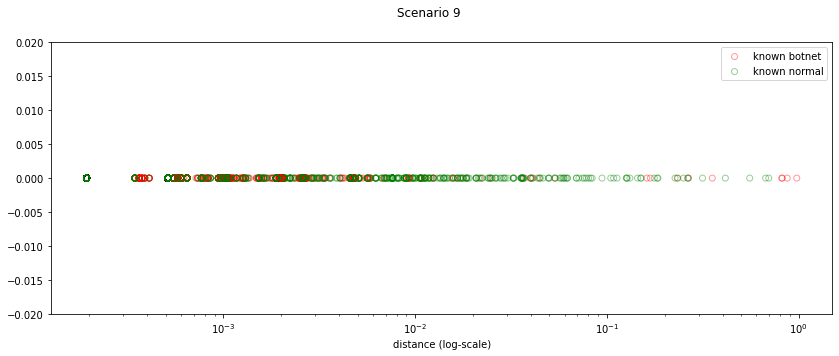

(3857,)


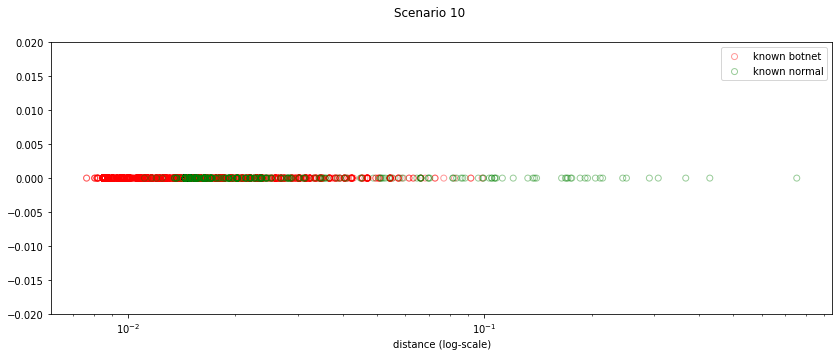

(159,)


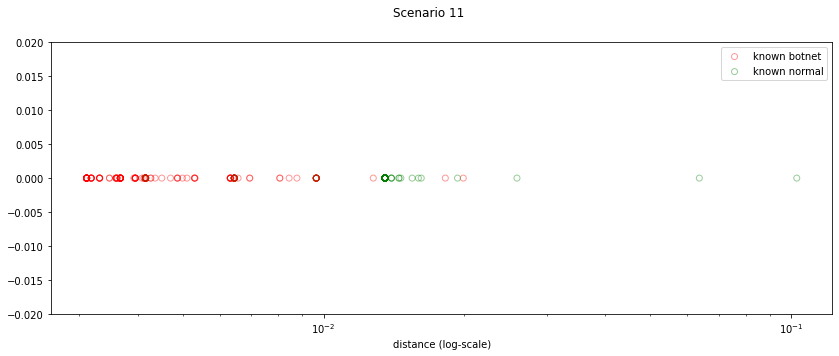

(50,)


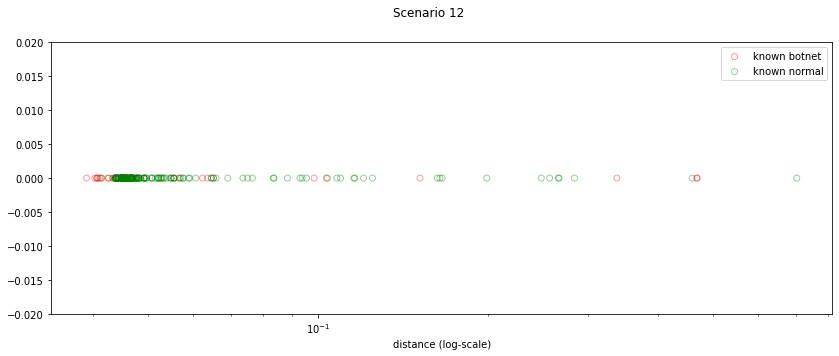

In [10]:
for scene in selected_scenarios:
    plot(dist_per_scene[scene],
         infected_IPs_per_scene[scene], 
         all_IPs_per_scene[scene], 
         'Scenario '+str(scene))

These are all profiles in each scenario

### Lets make predictions
for each IP we will pridict for each signature and find the mean prediction i.e. the more infected the signature/profile looks, more it tends to 1.


Scenario 9
mean pred = 1.0		| true = 0
mean pred = 0.952		| true = 0
mean pred = 0.9886363636363636		| true = 0
mean pred = 0.9857369255150554		| true = 0
mean pred = 1.0		| true = 1
mean pred = 0.9975339087546239		| true = 1
mean pred = 1.0		| true = 1
mean pred = 0.9986666666666667		| true = 1
mean pred = 1.0		| true = 1
mean pred = 1.0		| true = 1
mean pred = 1.0		| true = 1
mean pred = 0.9958041958041958		| true = 1
mean pred = 0.9954128440366973		| true = 1
mean pred = 1.0		| true = 0

Scenario 10
mean pred = 1.0		| true = 0
mean pred = 0.5476190476190477		| true = 0
mean pred = 0.9054054054054054		| true = 0
mean pred = 0.9459459459459459		| true = 0
mean pred = 0.9808153477218226		| true = 1
mean pred = 0.9782608695652174		| true = 1
mean pred = 0.9924812030075187		| true = 1
mean pred = 0.9955056179775281		| true = 1
mean pred = 0.9915433403805497		| true = 1
mean pred = 0.9977777777777778		| true = 1
mean pred = 1.0		| true = 1
mean pred = 0.9932279909706546		| true = 1
mean 

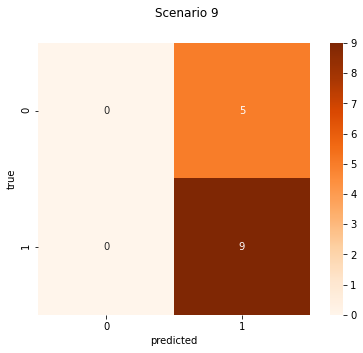

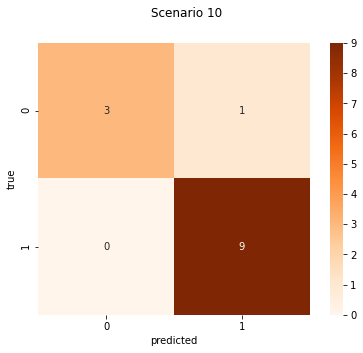

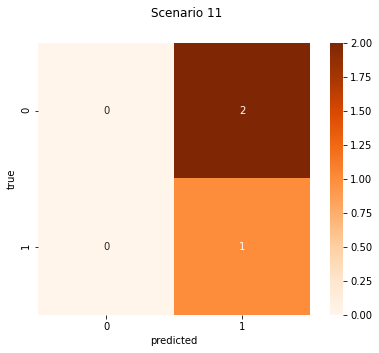

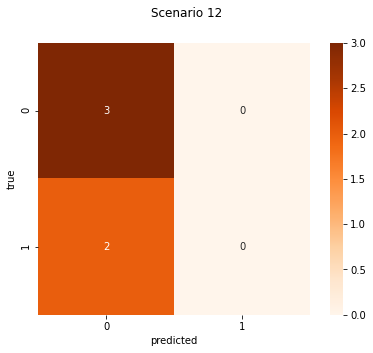

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LinearRegression

def make_clf(ip_distances:dict, infected_IPs, all_IPs):
    # make a simple linear classifier with tightest margin
    X = np.array([])
    Y = np.array([])
    keys = all_IPs
    for ip in all_IPs:
        dists = np.array(ip_distances[ip])
        X = np.concatenate([X, dists])
        if ip in infected_IPs:
            Y = np.concatenate([Y, np.ones(dists.shape[0])])
        else:
            Y = np.concatenate([Y, np.zeros(dists.shape[0])])

    X = X.reshape((-1,1))
    # print(X.shape)
    # print(Y.shape)

    clf = SGDClassifier(loss="hinge", alpha=1e-7, max_iter=1000)
    clf.fit(X,Y)
    return clf

def predict(clf, ip_distances:dict, infected_IPs, all_IPs):
    # for each ip find percentage of infected profiles in an IP
    Y_true = []
    Y_pred = []
    for ip in all_IPs:
        if ip in infected_IPs:
            true = 1
        else:
            true = 0
        Y_true.append(true)
        dists = np.array(ip_distances[ip]).reshape((-1,1))
        pred = clf.predict(dists)
        # print(pred)
        pred = np.mean(pred) # get percentage/ratio 
        print('mean pred = ' + str(pred) + '\t\t| true = ' + str(true))
        if pred > .95:
            Y_pred.append(1)
        else:
            Y_pred.append(0)
    return Y_true, Y_pred




for scene in selected_scenarios:
    print('\nScenario '+str(scene))
    clf = make_clf(dist_per_scene[scene], infected_IPs_per_scene[scene], all_IPs_per_scene[scene])
    Y_true, Y_pred = predict(clf, dist_per_scene[scene], infected_IPs_per_scene[scene], all_IPs_per_scene[scene])

    fig = plt.figure(figsize=(7,5))
    fig.suptitle('Scenario '+str(scene))
    conf = confusion_matrix(Y_true, Y_pred)
    sns.heatmap(conf, square=True, annot=True, cmap=plt.cm.Oranges)
    plt.ylabel('true')
    plt.xlabel('predicted')

### Explaination 
This method is definately good at identifyying new infections (True Positives) but raises many false alarms (False Positives).

We see that the model is very biased in different scenarios, especially 11 and 12. This may be because of hyperparameters such as:
- n-grams (n)
- sliding window (L and overlap)
- selection of features for sliding window and profiling
- infected IP selection (maybe, mostly not)
